<a href="https://colab.research.google.com/github/ayaemad10/detect-and-predict-of-the-space-debris/blob/main/V0_1_ARIMA_SARIMA_LSTM_REGRESSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import randrange
import matplotlib.pyplot as pl
from sklearn.preprocessing import LabelEncoder
from random import seed
from random import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go
from random import gauss
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd

# Load the data
file_path = '/content/Satellite1 Inertial Position Velocity.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe and its structure
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time (UTCG)  535 non-null    object 
 1   x (km)       535 non-null    float64
 2   y (km)       535 non-null    float64
 3   z (km)       535 non-null    float64
 4   vx (km/sec)  535 non-null    float64
 5   vy (km/sec)  535 non-null    float64
 6   vz (km/sec)  535 non-null    float64
dtypes: float64(6), object(1)
memory usage: 29.4+ KB


(               Time (UTCG)       x (km)       y (km)       z (km)  \
 0  1 Jan 2024 09:00:00.000 -6023.382815 -1169.994240 -3742.501344   
 1  1 Jan 2024 18:09:42.210  6917.466267  2100.135407   -16.101934   
 2  2 Jan 2024 06:00:59.793  6899.835043  2159.924424   -16.095453   
 3  2 Jan 2024 09:00:00.000   142.465775  1211.289281 -7085.017264   
 4  2 Jan 2024 18:43:05.776 -6842.377912 -2225.964237   103.453197   
 
    vx (km/sec)  vy (km/sec)  vz (km/sec)  
 0     3.503959     2.059760    -6.255137  
 1     0.372109    -1.088057     7.329252  
 2     0.381073    -1.084954     7.328452  
 3     7.113976     2.160192     0.492614  
 4    -0.436170     1.072610    -7.362618  ,
 None)

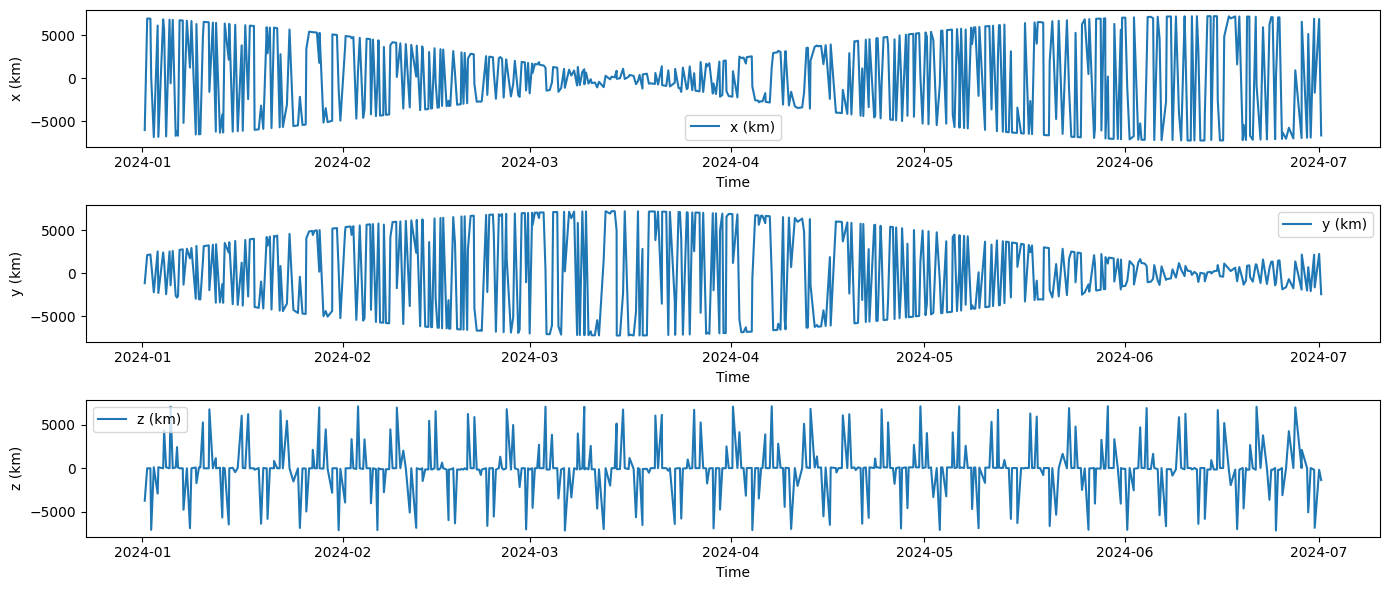

In [5]:
import matplotlib.pyplot as plt

# Convert 'Time (UTCG)' to datetime format
data['Time (UTCG)'] = pd.to_datetime(data['Time (UTCG)'])

# Plotting the positional data (x, y, z) over time
plt.figure(figsize=(14, 6))

plt.subplot(3, 1, 1)
plt.plot(data['Time (UTCG)'], data['x (km)'], label='x (km)')
plt.xlabel('Time')
plt.ylabel('x (km)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data['Time (UTCG)'], data['y (km)'], label='y (km)')
plt.xlabel('Time')
plt.ylabel('y (km)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(data['Time (UTCG)'], data['z (km)'], label='z (km)')
plt.xlabel('Time')
plt.ylabel('z (km)')
plt.legend()

plt.tight_layout()
plt.show()


# PolynomialFeatures

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare the data
X = data['Time (UTCG)'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)  # Convert datetime to ordinal
y_x = data['x (km)'].values
y_y = data['y (km)'].values
y_z = data['z (km)'].values

# Function to fit polynomial regression and make predictions
def fit_predict_polynomial(X, y, degree=7):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return y_pred, rmse, model

# Fit and predict for x, y, and z
y_x_pred, rmse_x, model_x = fit_predict_polynomial(X, y_x)
y_y_pred, rmse_y, model_y = fit_predict_polynomial(X, y_y)
y_z_pred, rmse_z, model_z = fit_predict_polynomial(X, y_z)

rmse_x, rmse_y, rmse_z

(4604.255877922564, 4692.683819001023, 2942.636995282847)

In [7]:
from plotly.subplots import make_subplots

def plot_actual_vs_predicted(y_x_pred, y_y_pred, y_z_pred):
    # Create figure with subplots
    fig = make_subplots(rows=3, cols=1)

    # Add traces for x (km)
    fig.add_trace(go.Scatter(x=data['Time (UTCG)'], y=data['x (km)'], name='Actual x (km)', line=dict(color='blue')), row=1, col=1)
    fig.add_trace(go.Scatter(x=data['Time (UTCG)'], y=y_x_pred, name='Predicted x (km)', line=dict(color='red', dash='dash')), row=1, col=1)

    # Add traces for y (km)
    fig.add_trace(go.Scatter(x=data['Time (UTCG)'], y=data['y (km)'], name='Actual y (km)', line=dict(color='blue')), row=2, col=1)
    fig.add_trace(go.Scatter(x=data['Time (UTCG)'], y=y_y_pred, name='Predicted y (km)', line=dict(color='red', dash='dash')), row=2, col=1)

    # Add traces for z (km)
    fig.add_trace(go.Scatter(x=data['Time (UTCG)'], y=data['z (km)'], name='Actual z (km)', line=dict(color='blue')), row=3, col=1)
    fig.add_trace(go.Scatter(x=data['Time (UTCG)'], y=y_z_pred, name='Predicted z (km)', line=dict(color='red', dash='dash')), row=3, col=1)

    # Update layout
    fig.update_layout(
        title_text="Actual vs Predicted Values",
        height=800,
    width=1200,
    showlegend=True,
    )

    # Create subplots arrangement and customize axis colors
    fig.update_layout(
        xaxis=dict(title_text="Time", color='green'),
        yaxis=dict(title_text="x (km)", color='green'),
        xaxis2=dict(title_text="Time", color='purple'),
        yaxis2=dict(title_text="y (km)", color='purple'),
        xaxis3=dict(title_text="Time", color='brown'),
        yaxis3=dict(title_text="z (km)", color='brown'),
        grid=dict(rows=3, columns=1, pattern='independent')
    )

    fig.show()
plot_actual_vs_predicted(y_x_pred, y_y_pred, y_z_pred)

In [8]:
from sklearn.svm import SVR

def fit_predict_svr(X, y, kernel='rbf', C=1, epsilon=0.1):
  model = SVR(kernel=kernel, C=C, epsilon=epsilon)
  model.fit(X, y)
  y_pred = model.predict(X)
  mse = mean_squared_error(y, y_pred)
  return y_pred, mse, model

# Fit and predict for x, y, and z
y_x_pred_svr, mse_x_svr, model_x_svr = fit_predict_svr(X, y_x)
y_y_pred_svr, mse_y_svr, model_y_svr = fit_predict_svr(X, y_y)
y_z_pred_svr, mse_z_svr, model_z_svr = fit_predict_svr(X, y_z)

mse_x_svr, mse_y_svr, mse_z_svr

(21227361.65237353, 22076090.111470614, 8665023.701723075)

In [9]:
# plot_actual_vs_predicted(y_x_pred_svr, y_y_pred_svr, y_z_pred_svr)

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

def fit_predict_gradient_boosting(X, y, n_estimators=100, learning_rate=0.1):
  model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
  model.fit(X, y)
  y_pred = model.predict(X)
  mse = mean_squared_error(y, y_pred)
  return y_pred, mse, model

# Fit and predict for x, y, and z
y_x_pred_gd, mse_x_gd, model_x_gd = fit_predict_gradient_boosting(X, y_x)
y_y_pred_gd, mse_y_gd, model_y_gd = fit_predict_gradient_boosting(X, y_y)
y_z_pred_gd, mse_z_gd, model_z_gd = fit_predict_gradient_boosting(X, y_z)

mse_x_gd, mse_y_gd, mse_z_gd

(16740273.283902783, 15676050.193199346, 7081337.935894672)

In [11]:
plot_actual_vs_predicted(y_x_pred_gd, y_y_pred_gd, y_z_pred_gd)

# RandomForestRegressor

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
from sklearn.ensemble import RandomForestRegressor

def fit_predict_random_forest(X, y, n_estimators=100):
  model = RandomForestRegressor(n_estimators=n_estimators)
  model.fit(X, y)
  y_pred = model.predict(X)
  mse = mean_squared_error(y, y_pred)
  return y_pred, mse, model

# Fit and predict for x, y, and z
y_x_pred_rd, mse_x_rd, model_x_rd = fit_predict_random_forest(X, y_x)
y_y_pred_rd, mse_y_rd, model_y_rd = fit_predict_random_forest(X, y_y)
y_z_pred_rd, mse_z_rd, model_z_rd = fit_predict_random_forest(X, y_z)

mse_x_rd, mse_y_rd, mse_z_rd

(15096534.031702053, 13866414.850607008, 5603988.731947279)

In [14]:
plot_actual_vs_predicted(y_x_pred_rd, y_y_pred_rd, y_z_pred_rd)

# ExponentialSmoothing

In [15]:
# Fit exponential smoothing models
model_x = ExponentialSmoothing(y_x, trend='add', seasonal=None, seasonal_periods=None).fit()
model_y = ExponentialSmoothing(y_y, trend='add', seasonal=None, seasonal_periods=None).fit()
model_z = ExponentialSmoothing(y_z, trend='add', seasonal=None, seasonal_periods=None).fit()

# Make predictions
y_x_pred_exp = model_x.fittedvalues
y_y_pred_exp = model_y.fittedvalues
y_z_pred_exp = model_z.fittedvalues

# Calculate mean squared error
rmse_x_exp = np.sqrt(mean_squared_error(y_x, y_x_pred_exp))
rmse_y_exp = np.sqrt(mean_squared_error(y_y, y_y_pred_exp))
rmse_z_exp = np.sqrt(mean_squared_error(y_z, y_z_pred_exp))

rmse_x_exp, rmse_y_exp, rmse_z_exp

(4746.574416861072, 4830.021057939972, 3134.987375687627)

In [16]:
plot_actual_vs_predicted(y_x_pred_exp, y_y_pred_exp, y_z_pred_exp)

# ARIMA +  SARIMA + LSTM + GRU

In [17]:
# Load the data
file_path = '/content/Satellite1 Inertial Position Velocity.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe and its structure
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time (UTCG)  535 non-null    object 
 1   x (km)       535 non-null    float64
 2   y (km)       535 non-null    float64
 3   z (km)       535 non-null    float64
 4   vx (km/sec)  535 non-null    float64
 5   vy (km/sec)  535 non-null    float64
 6   vz (km/sec)  535 non-null    float64
dtypes: float64(6), object(1)
memory usage: 29.4+ KB


(               Time (UTCG)       x (km)       y (km)       z (km)  \
 0  1 Jan 2024 09:00:00.000 -6023.382815 -1169.994240 -3742.501344   
 1  1 Jan 2024 18:09:42.210  6917.466267  2100.135407   -16.101934   
 2  2 Jan 2024 06:00:59.793  6899.835043  2159.924424   -16.095453   
 3  2 Jan 2024 09:00:00.000   142.465775  1211.289281 -7085.017264   
 4  2 Jan 2024 18:43:05.776 -6842.377912 -2225.964237   103.453197   
 
    vx (km/sec)  vy (km/sec)  vz (km/sec)  
 0     3.503959     2.059760    -6.255137  
 1     0.372109    -1.088057     7.329252  
 2     0.381073    -1.084954     7.328452  
 3     7.113976     2.160192     0.492614  
 4    -0.436170     1.072610    -7.362618  ,
 None)

In [18]:
# Convert the 'Time (UTCG)' column to datetime and set it as the index
data['Time (UTCG)'] = pd.to_datetime(data['Time (UTCG)'], format='%d %b %Y %H:%M:%S.%f')
data.set_index('Time (UTCG)', inplace=True)

# Extract the time series for x, y, and z coordinates
ts_x = data['x (km)']
ts_y = data['y (km)']
ts_z = data['z (km)']

# Display the first few rows of each time series
ts_x.head(), ts_y.head(), ts_z.head()

(Time (UTCG)
 2024-01-01 09:00:00.000   -6023.382815
 2024-01-01 18:09:42.210    6917.466267
 2024-01-02 06:00:59.793    6899.835043
 2024-01-02 09:00:00.000     142.465775
 2024-01-02 18:43:05.776   -6842.377912
 Name: x (km), dtype: float64,
 Time (UTCG)
 2024-01-01 09:00:00.000   -1169.994240
 2024-01-01 18:09:42.210    2100.135407
 2024-01-02 06:00:59.793    2159.924424
 2024-01-02 09:00:00.000    1211.289281
 2024-01-02 18:43:05.776   -2225.964237
 Name: y (km), dtype: float64,
 Time (UTCG)
 2024-01-01 09:00:00.000   -3742.501344
 2024-01-01 18:09:42.210     -16.101934
 2024-01-02 06:00:59.793     -16.095453
 2024-01-02 09:00:00.000   -7085.017264
 2024-01-02 18:43:05.776     103.453197
 Name: z (km), dtype: float64)

In [19]:
def split_data(ts_data):
  train_size = int(len(ts_data) * 0.8)
  train, test = ts_data[:train_size], ts_data[train_size:]
  return train, test, train_size

train_x, test_x, train_size_x  = split_data(ts_x)
train_y, test_y, train_size_y = split_data(ts_y)
train_z, test_z, train_size_z = split_data(ts_z)

In [20]:
!pip install --upgrade statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

def evaluate_arima_sarima(ts_data):
  """
  Evaluates ARIMA and SARIMA models for a given time series.

  Args:
    ts_data: The time series data as a numpy array.

  Returns:
    A tuple containing ARIMA and SARIMA RMSE values.
  """

  # Split data
  train_size = int(len(ts_data) * 0.8)
  train, test = ts_data[:train_size], ts_data[train_size:]

  # ARIMA model
  arima_model = ARIMA(train, order=(5, 1, 0))
  arima_fit = arima_model.fit()
  arima_forecast = arima_fit.forecast(steps=len(test))

  # SARIMA model
  sarima_model = SARIMAX(train, order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
  sarima_fit = sarima_model.fit(disp=False)
  sarima_forecast = sarima_fit.forecast(steps=len(test))

  # Evaluation function
  def evaluate_forecast(actual, forecast):
    return np.sqrt(mean_squared_error(actual, forecast))

  # Evaluate models
  arima_rmse = evaluate_forecast(test, arima_forecast)
  sarima_rmse = evaluate_forecast(test, sarima_forecast)

  return arima_rmse, sarima_rmse, arima_forecast , sarima_forecast

In [21]:
time_steps=10
def lstm_model(ts_data):
    """
    Builds and trains an LSTM model for time series forecasting.

    Args:
      data: The time series data as a numpy array.
      time_steps: The number of time steps for input sequences.

    Returns:
      A tuple containing the trained model, scaled data, and scaler object.
    """


    # Split data
    train_size = int(len(ts_data) * 0.8) # Correct indentation for this line
    train, test = ts_data[:train_size], ts_data[train_size:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))
    scaled_test = scaler.transform(test.values.reshape(-1, 1))

    # Evaluation function
    def evaluate_forecast(actual, forecast):
        return np.sqrt(mean_squared_error(actual, forecast))

    # Prepare the data for LSTM
    def create_dataset(data, time_step=1):
        X, Y = [], []
        for i in range(len(data)-time_step-1):
            a = data[i:(i+time_step), 0]
            X.append(a)
            Y.append(data[i + time_step, 0])
        return np.array(X), np.array(Y)

    time_step = 10
    X_train, y_train = create_dataset(scaled_train, time_step)
    X_test, y_test = create_dataset(scaled_test, time_step)

    # Reshape input to be [samples, time steps, features] for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=1, epochs=1)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverse transform the predictions
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Evaluate the LSTM model
    lstm_rmse = evaluate_forecast(test[time_step+1:], test_predict)
    # print("LSTM RMSE:", lstm_rmse)

    return lstm_rmse, test_predict

In [22]:
time_steps=10
def gru_model(ts_data):
    """
    Builds and trains an LSTM model for time series forecasting.

    Args:
      data: The time series data as a numpy array.
      time_steps: The number of time steps for input sequences.

    Returns:
      A tuple containing the trained model, scaled data, and scaler object.
    """


    # Split data
    train_size = int(len(ts_data) * 0.8) # Correct indentation for this line
    train, test = ts_data[:train_size], ts_data[train_size:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_train = scaler.fit_transform(train.values.reshape(-1, 1))
    scaled_test = scaler.transform(test.values.reshape(-1, 1))

    # Evaluation function
    def evaluate_forecast(actual, forecast):
        return np.sqrt(mean_squared_error(actual, forecast))

    # Prepare the data for LSTM
    def create_dataset(data, time_step=1):
        X, Y = [], []
        for i in range(len(data)-time_step-1):
            a = data[i:(i+time_step), 0]
            X.append(a)
            Y.append(data[i + time_step, 0])
        return np.array(X), np.array(Y)

    time_step = 10
    X_train, y_train = create_dataset(scaled_train, time_step)
    X_test, y_test = create_dataset(scaled_test, time_step)

    # Reshape input to be [samples, time steps, features] for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build the LSTM model
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(GRU(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=1, epochs=1)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverse transform the predictions
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Evaluate the LSTM model
    gru_rmse = evaluate_forecast(test[time_step+1:], test_predict)
    # print("LSTM RMSE:", lstm_rmse)

    return gru_rmse, test_predict

In [23]:
import plotly.graph_objects as go
def plot_actual_vs_predicted(name, ts_z, arima_forecast_z, sarima_forecast_z, test_predict_z_lstm, test_predict_z_gru, time_step, train_size_z, test_z):
    # Create the figure
    fig = go.Figure()

    # Add traces for actual and predicted values
    fig.add_trace(go.Scatter(x=ts_x.index[train_size_z:], y=test_z, mode='lines', name='Actual', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=ts_x.index[train_size_z:], y=arima_forecast_z, mode='lines', name='ARIMA', line=dict(color='red')))
    fig.add_trace(go.Scatter(x=ts_x.index[train_size_z:], y=sarima_forecast_z, mode='lines', name='SARIMA', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=ts_x.index[train_size_z+ time_step +1:], y=test_predict_z_lstm, mode='lines', name='LSTM', line=dict(color='orange')))
    fig.add_trace(go.Scatter(x=ts_x.index[train_size_z+ time_step +1:], y=test_predict_z_gru, mode='lines', name='GRU', line=dict(color='black')))

    # Update layout
    fig.update_layout(title_text= f'Actual vs Predicted Values for {name}',
                      xaxis_title='Time',
                      yaxis_title= f'{name} (km)')

    # Show the plot
    fig.show()


In [24]:
arima_rmse_x, sarima_rmse_x, arima_forecast_x, sarima_forecast_x = evaluate_arima_sarima(ts_x)
print("ARIMA RMSE FOR X:", arima_rmse_x)
print("SARIMA RMSE FOR X:", sarima_rmse_x)

ARIMA RMSE FOR X: 7176.458668929538
SARIMA RMSE FOR X: 6920.370432705337


In [25]:
lstm_rmse_x, test_predict_x_lstm = lstm_model(ts_x)
print("LSTM RMSE FOR X: ", lstm_rmse_x)

3/3 [==============================] - 0s 8ms/step
LSTM RMSE FOR X:  6496.3816064695275


In [26]:
gru_rmse_x, test_predict_x_gru = gru_model(ts_x)
print("GRU RMSE FOR X: ", gru_rmse_x)

3/3 [==============================] - 0s 6ms/step
GRU RMSE FOR X:  6669.451738131219


In [27]:
import plotly.graph_objects as go

def plot_actual_vs_predicted(name, ts_z, arima_forecast_z, sarima_forecast_z, test_predict_z_lstm, test_predict_z_gru, time_step, train_size_z, test_z):
    # Create the figure
    fig = go.Figure()

    # Add traces for actual and predicted values
    fig.add_trace(go.Scatter(x=ts_z.index[train_size_z:], y=test_z, mode='lines', name='Actual', line=dict(color='blue'))) # Use ts_z instead of ts_x
    fig.add_trace(go.Scatter(x=ts_z.index[train_size_z:], y=arima_forecast_z, mode='lines', name='ARIMA', line=dict(color='red'))) # Use ts_z instead of ts_x
    fig.add_trace(go.Scatter(x=ts_z.index[train_size_z:], y=sarima_forecast_z, mode='lines', name='SARIMA', line=dict(color='green'))) # Use ts_z instead of ts_x
    fig.add_trace(go.Scatter(x=ts_z.index[train_size_z+ time_step +1:], y=test_predict_z_lstm, mode='lines', name='LSTM', line=dict(color='orange')))
    fig.add_trace(go.Scatter(x=ts_z.index[train_size_z+ time_step +1:], y=test_predict_z_gru, mode='lines', name='GRU', line=dict(color='black')))

    # Update layout
    fig.update_layout(title_text= f'Actual vs Predicted Values for {name}',
                      xaxis_title='Time',
                      yaxis_title= f'{name} (km)')

    # Show the plot
    fig.show()

# Assuming time_step is defined somewhere before calling the function, for example:
time_step = 10
plot_actual_vs_predicted("X", ts_x, arima_forecast_x, sarima_forecast_x, test_predict_x_lstm, test_predict_x_gru, time_step, train_size_x, test_x)

In [28]:
arima_rmse_y, sarima_rmse_y,  arima_forecast_y, sarima_forecast_y = evaluate_arima_sarima(ts_y)
print("ARIMA RMSE FOR Y:", arima_rmse_y)
print("SARIMA RMSE FOR Y:", sarima_rmse_y)

ARIMA RMSE FOR Y: 2083.0311956791543
SARIMA RMSE FOR Y: 2347.363209525237


In [29]:
lstm_rmse_y, test_predict_y = lstm_model(ts_y)
print("LSTM RMSE FOR Y: ", lstm_rmse_y)

3/3 [==============================] - 0s 6ms/step
LSTM RMSE FOR Y:  1239.4657345321862


In [30]:
gru_rmse_y, test_predict_y_gru = gru_model(ts_y)
print("GRU RMSE FOR Y: ", gru_rmse_y)

3/3 [==============================] - 0s 7ms/step
GRU RMSE FOR Y:  1367.3141972949277


In [31]:
plot_actual_vs_predicted("Y", ts_y, arima_forecast_y, sarima_forecast_y, test_predict_y, test_predict_y_gru, time_step, train_size_y, test_y)

In [32]:
arima_rmse_z, sarima_rmse_z, arima_forecast_z, sarima_forecast_z = evaluate_arima_sarima(ts_z)
print("ARIMA RMSE FOR Z:", arima_rmse_z)
print("SARIMA RMSE FOR Z:", sarima_rmse_z)

ARIMA RMSE FOR Z: 3464.073741229831
SARIMA RMSE FOR Z: 3472.4036057327776


In [33]:
lstm_rmse_z, test_predict_z = lstm_model(ts_z)
print("LSTM RMSE FOR Z: ", lstm_rmse_y)

3/3 [==============================] - 0s 6ms/step
LSTM RMSE FOR Z:  1239.4657345321862


In [34]:
gru_rmse_z, test_predict_z_gru = gru_model(ts_z)
print("GRU RMSE FOR Z: ", gru_rmse_z)

3/3 [==============================] - 0s 6ms/step
GRU RMSE FOR Z:  3021.729319701281


In [35]:
plot_actual_vs_predicted("Z", ts_z, arima_forecast_z, sarima_forecast_z, test_predict_z, test_predict_z_gru, time_step, train_size_z, test_z)